Libraries and Google Drive.

In [ ]:
from pandas import DataFrame,read_csv
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
from prettytable import PrettyTable
drive.mount('/content/drive')
directory_path = '/content/drive/My Drive/sendToDrive2019'

Mounted at /content/drive


# **1.CREATE train.csv file and DataFrame**

The code below has to do with the concatination of the given listings for each month. The columns are created , we iterate through each file in order to find and drop the columns that are not desirable. Finally it creates the file.
host_id column is included for the preparation of the query 1.14





In [ ]:
columns=['id','zipcode','transit','bedrooms','beds','review_scores_rating',
         'number_of_reviews', 'host_id',
         'neighbourhood','name','latitude','longitude','last_review',
         'instant_bookable','host_since',
         'host_response_rate','host_identity_verified',
         'host_has_profile_pic','first_review','description','city',
         'cancellation_policy','bed_type','bathrooms','accommodates',
         'amenities','room_type','property_type','price',
         'availability_365','minimum_nights']

april_df=pd.DataFrame()
Location = r'/content/drive/My Drive/sendToDrive2019/april.csv'
april_df=pd.read_csv(Location,low_memory=False)


for x in april_df:
    if x not in columns:
        del april_df[x]

#add month column
april_df['Month'] = 'April'

february_df=pd.DataFrame()
Location = r'/content/drive/My Drive/sendToDrive2019/february.csv'
february_df=pd.read_csv(Location,low_memory=False)

for x in february_df:
    if x not in columns:
        del february_df[x]


#add month column
february_df['Month'] = 'February'

march_df=pd.DataFrame()
Location = r'/content/drive/My Drive/sendToDrive2019/march.csv'
march_df=pd.read_csv(Location, low_memory=False)

for x in march_df:
    if x not in columns:
        del march_df[x]

#add month column
march_df['Month'] = 'March'

df = pd.concat([april_df,february_df,march_df])
count = 0
# for x in df:
#     count +=1
#     print(x)
# print(count)

df.to_csv('/content/drive/My Drive/sendToDrive2019/train.csv' , index=False)

Clean the data after creating the DataFrame . Numeric columns are selected and negative values are dropped(Price column is transformed to numeric so it can be included).Calculate the zscore of each column and drop the outliers. Then calculate again the mean and fillna.

In [ ]:
df=pd.DataFrame()
Location = r'/content/drive/My Drive/sendToDrive2019/train.csv'
df = pd.read_csv(Location , low_memory= False , index_col = 'id')

df['price'] = df['price'].str.replace('$', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')#add NaN values

# Find the mean and the st.deviation of the numeric columns , implement zscore to find and drop outliers
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = df[numeric_columns].mask(df[numeric_columns] <= 0)
mean_no_nan = df[numeric_columns].agg(['mean' , 'std'])
# zscore
df_zscore = (df[numeric_columns] - mean_no_nan.loc['mean'] ) / mean_no_nan.loc['std']
df_zscore.columns = [col + '_zscore' for col in df_zscore.columns]
df = pd.concat([df, df_zscore], axis=1)

df[df_zscore.columns] = df[df_zscore.columns].mask( (2.5 <= df[df_zscore.columns])  , -10 )
df[df_zscore.columns] = df[df_zscore.columns].mask( (df[df_zscore.columns] <= -2.5)  , -10 )
rows_to_drop = df[(df == -10).any(axis=1)]
df = df.drop(rows_to_drop.index)
# Drop the columns i created for zscore
columns_to_drop = df.filter(like='_zscore').columns
df.drop(columns=columns_to_drop, inplace=True)

df.loc[:, numeric_columns] = df.loc[:, numeric_columns].fillna(df[numeric_columns].mean())

# 1.1
Most common room_type.


O πιο συχνός τύπος δωματίου Entire home/apt


<Axes: title={'center': 'Τύποι δωματίων'}, ylabel='room_type'>

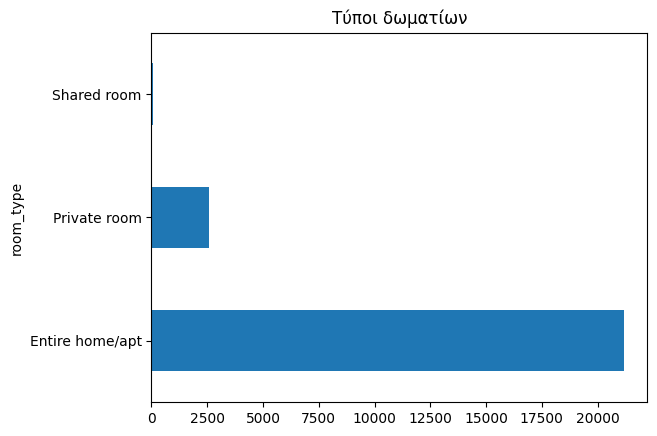

In [ ]:
room_type1 = df.groupby(['room_type']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
most_common_room_type = room_type1.head(1)
most_common_room_type_name = most_common_room_type['room_type'].iloc[0]
print("O πιο συχνός τύπος δωματίου", most_common_room_type_name)
room_type1.plot(kind='barh', x='room_type', y='counts', title='Τύποι δωματίων', legend=False)

# 1.2
Aggregation of price per month.

<Axes: xlabel='Month'>

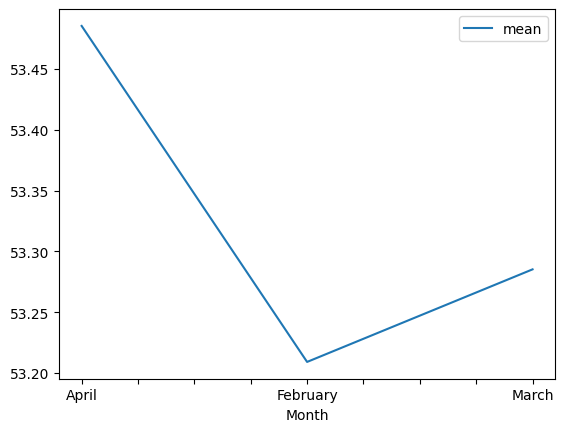

In [ ]:
grouped = df.groupby('Month')['price'].agg(['count', 'mean']).reset_index()
grouped.plot(x='Month', y='mean', kind='line')

# 1.3
Neighbourhoods with the most reviews.

Grouping with sum of 'number_of_reviews.

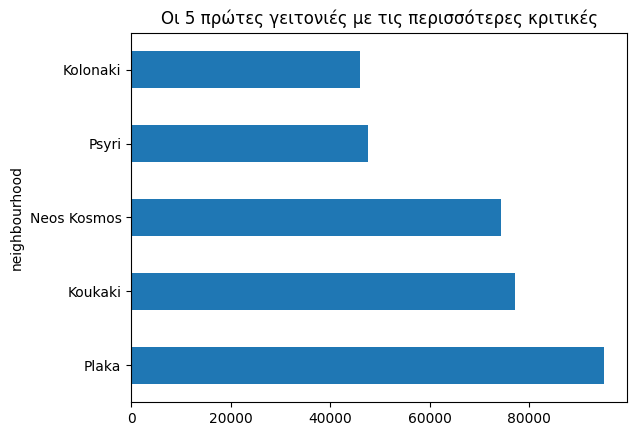

In [ ]:
neighbourhood = df.groupby(['neighbourhood']).sum()['number_of_reviews'].nlargest(5)
ax = neighbourhood.plot(kind='barh', title='Οι 5 πρώτες γειτονιές με τις περισσότερες κριτικές', legend=False)

# 1.4
Neighbourhoods with the most Realties.


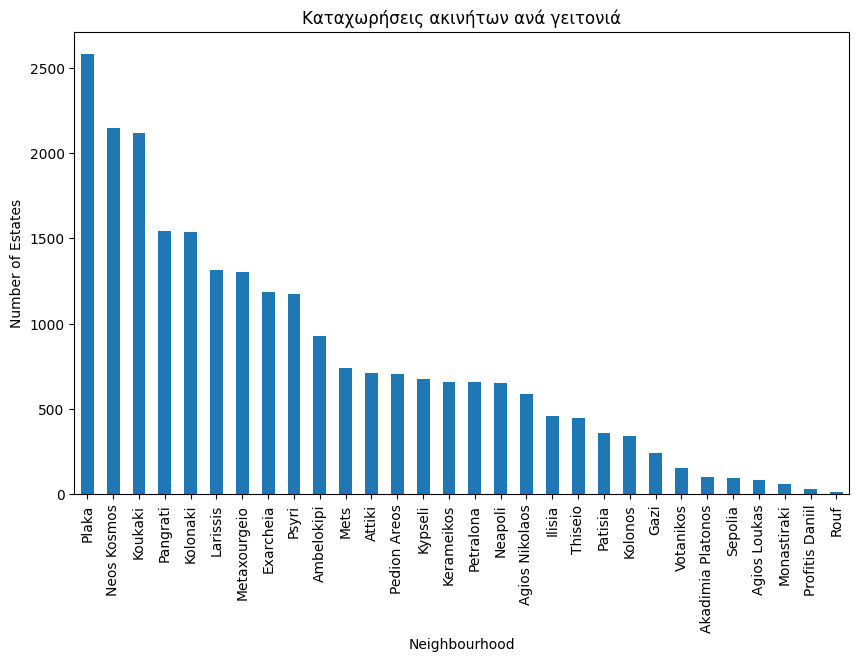

In [ ]:
neigh_estate_counts = df['neighbourhood'].value_counts()
neigh_estate_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Καταχωρήσεις ακινήτων ανά γειτονιά')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Estates')
plt.show()

# 1.5

Most entries perMonth and perNeighbourhood.

        neighbourhood  April  February  March  Total
23              Plaka    916       816    846   2578
18        Neos Kosmos    739       694    716   2149
11            Koukaki    738       675    703   2116
19           Pangrati    545       473    526   1544
9            Kolonaki    546       471    522   1539
13           Larissis    455       415    446   1316
14       Metaxourgeio    449       414    442   1305
5           Exarcheia    429       341    416   1186
25              Psyri    401       386    389   1176
3          Ambelokipi    312       294    321    927
15               Mets    241       266    235    742
4              Attiki    252       221    239    712
21       Pedion Areos    211       278    214    703
12            Kypseli    254       161    261    676
8          Kerameikos    308        30    320    658
22          Petralona    231       212    214    657
17            Neapoli    193       276    186    655
1      Agios Nikolaos    201       188    197 

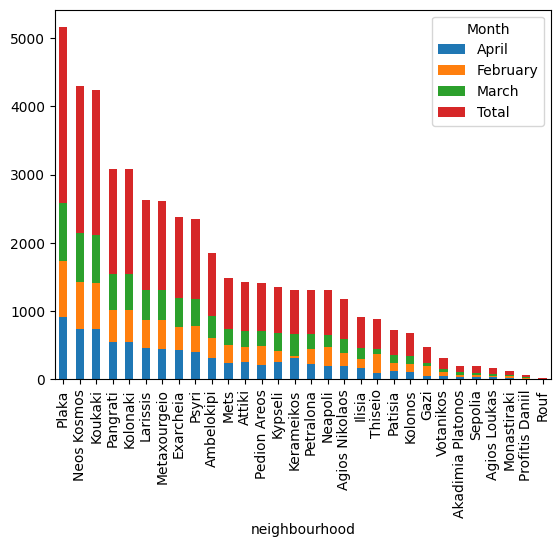

In [ ]:
neigh_counts = df.groupby(['neighbourhood', 'Month']).size().reset_index(name='Entry_Count')
neigh_pivot = neigh_counts.pivot(index='neighbourhood', columns='Month', values='Entry_Count').reset_index()
neigh_pivot['Total'] = neigh_pivot[['April', 'February', 'March']].sum(axis=1)
neigh_pivot = neigh_pivot.sort_values(by='Total', ascending=False)
neigh_pivot.plot(kind='bar', x='neighbourhood', y=['April', 'February', 'March', 'Total'], stacked=True)
neigh_pivot.columns.name = None
print(neigh_pivot)

# 1.7
Use of size() with groupby to find the most common room_type and then get the first index with idxmax() in each neighbourhood.

In [ ]:
table = PrettyTable()
table.field_names = ["Neighbourhood", "room_type"]
counts_per_neigh = df.groupby(['neighbourhood', 'room_type']).size()
most_common = counts_per_neigh.groupby('neighbourhood').idxmax()
for neigh, (neigh2, rmtp) in most_common.items():#idmax returns tuple so i must need to extract he room_type
    table.add_row([neigh, rmtp])
print(table)

+-------------------+-----------------+
|   Neighbourhood   |    room_type    |
+-------------------+-----------------+
|    Agios Loukas   | Entire home/apt |
|   Agios Nikolaos  | Entire home/apt |
| Akadimia Platonos | Entire home/apt |
|     Ambelokipi    | Entire home/apt |
|       Attiki      | Entire home/apt |
|     Exarcheia     | Entire home/apt |
|        Gazi       | Entire home/apt |
|       Ilisia      | Entire home/apt |
|     Kerameikos    | Entire home/apt |
|      Kolonaki     | Entire home/apt |
|      Kolonos      | Entire home/apt |
|      Koukaki      | Entire home/apt |
|      Kypseli      | Entire home/apt |
|      Larissis     | Entire home/apt |
|    Metaxourgeio   | Entire home/apt |
|        Mets       | Entire home/apt |
|    Monastiraki    | Entire home/apt |
|      Neapoli      | Entire home/apt |
|    Neos Kosmos    | Entire home/apt |
|      Pangrati     | Entire home/apt |
|      Patisia      | Entire home/apt |
|    Pedion Areos   | Entire home/apt |


# 1.8

Most expensive room_type.

A simple aggregation using groupby.


In [ ]:
table = PrettyTable(['room_type', 'mean'])
grouped = df.groupby('room_type')['price'].agg(['mean']).reset_index()
for index, row in grouped.iterrows():
    table.add_row([row['room_type'], row['mean']])
print(table)

+-----------------+--------------------+
|    room_type    |        mean        |
+-----------------+--------------------+
| Entire home/apt | 54.46794313249465  |
|   Private room  | 44.80761308466211  |
|   Shared room   | 22.835616438356166 |
+-----------------+--------------------+


# 1.9
Creation of a new df consisting rows with the specified month , then i sample 300 rows and show the popus on the map

In [ ]:
import folium
df_march = df[df['Month'] == 'March']
m = folium.Map()
# Iterate over the DataFrame and add markers with popups
for index, row in df_march.sample(n=300).iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['room_type']).add_to(m)
m

# 1.10
Use of wordcloud library.

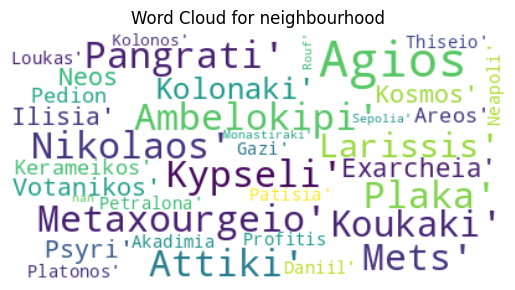

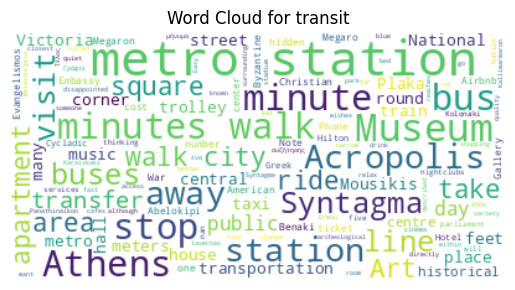

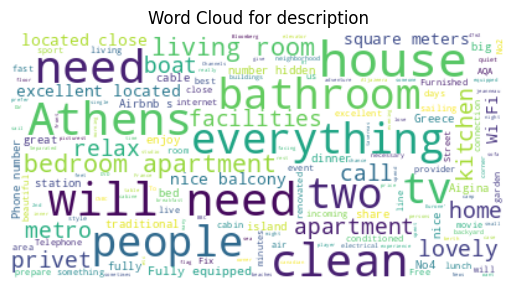

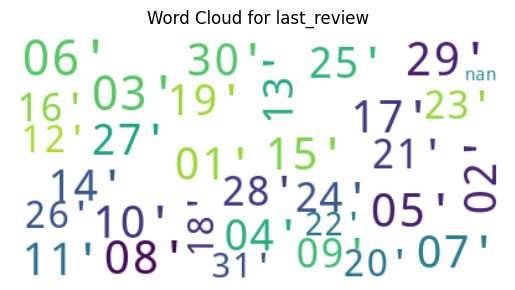

In [ ]:
from wordcloud import WordCloud , STOPWORDS

stopwords = set(STOPWORDS)
columns = ['neighbourhood', 'transit', 'description' , 'last_review' ]

for column in columns:
    # Generate word cloud for the current column
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        random_state=42
    ).generate(str(df[column].unique()))

    # Plot the word cloud
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}')
    plt.show()


# 1.11
Group the amenities column in more organised way.

I used "pd.set_option('display.max_colwidth', None)" so i can read some cells , i created a dictionary with the keys bein the categories and the values the corresponding text.Then implement the reverse mapping between items and keys and finally iterate through text to find and replace the items with the corresponding category.

In [ ]:
import re
amendict = {}
amendict['kithcen'] = ["Coffee maker","Refrigerator","Dishes and silverware","Cooking basics","Oven","Stove" , "Microwave"]
amendict['accesibility'] =["Elevator","Buzzer/wireless intercom" , "Wheelchair accessible" ,"Step-free access" , "Private entrance","Wide doorway","Flat path to front door","Well-lit path to entrance" ,
                           "Self check-in"]
amendict['Electricity_and_Technology' ] = ["TV","Cable TV","Internet","Wifi" , "Ethernet connection"]
amendict['facilities'] = ["Paid parking off premises" , "Free street parking" ,"Single level home",  "Laptop friendly workspace","Private living room" ,"Room-darkening shades" , "Garden or backyard" ]

amendict['services'] = ["Luggage dropoff allowed" , "Host greets you" , "Hot water","Bed linens","Extra pillows and blankets" , "Handheld shower head" , "Air conditioning" ,
                        "Heating","Washer","Dryer" ,"Shampoo","Hangers","Hair dryer","Iron" , "Bathtub"]
amendict['security'] = ["Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher"]

reverse_mapping = {item.lower(): key for key, values in amendict.items() for item in values}

def replace_amenities(text):
    matches = re.findall(r'"([^"]+)"|\b(\w+)\b', text)
    replaced_items = []
    for match in matches:
        item = match[0] or match[1]  # Select the matched group
        item_lower = item.lower()
        if item_lower in reverse_mapping:
            replaced_items.append(reverse_mapping[item_lower])
        else:
            replaced_items.append(item)
    return ', '.join(replaced_items)

# Apply the replacement function to the 'amenities' column
df['amenities'] = df['amenities'].apply(replace_amenities)
df['amenities'] = df['amenities'].replace(reverse_mapping)
pd.set_option('display.max_colwidth', None)
print(df['amenities'].sample(10))


id
28060848                                                                                                                                        Electricity_and_Technology, services, Kitchen, accesibility, facilities, services, security, security, security, security, Essentials, services, Lock, on, bedroom, door, services, services, services, accesibility, services, Electricity_and_Technology, Long, term, stays, allowed, services
32827460                                                                                                                                                                                                                                                                         Electricity_and_Technology, Electricity_and_Technology, services, Kitchen, accesibility, services, services, Essentials, services, services, services, services
23211401                                                                                                                           

# 1.12

Grouping Neighbourhoods to [Expensive , MidPrice , Inexpensive].

Aggregating using groupby and then split the 30 neighbourhoods to the 3 requested categories .

ExpensiveNeighbourhoods:['Profitis Daniil', 'Psyri', 'Monastiraki', 'Plaka', 'Thiseio', 'Kolonaki', 'Metaxourgeio', 'Neos Kosmos', 'Kerameikos', 'Ilisia']
MiddlePriceNeighbourhoods:['Akadimia Platonos', 'Koukaki', 'Mets', 'Pangrati', 'Gazi', 'Exarcheia', 'Petralona', 'Neapoli', 'Votanikos']
InexpensiveNeighbourhoods:['Ambelokipi', 'Patisia', 'Attiki', 'Pedion Areos', 'Kypseli', 'Larissis', 'Agios Nikolaos', 'Sepolia', 'Agios Loukas']


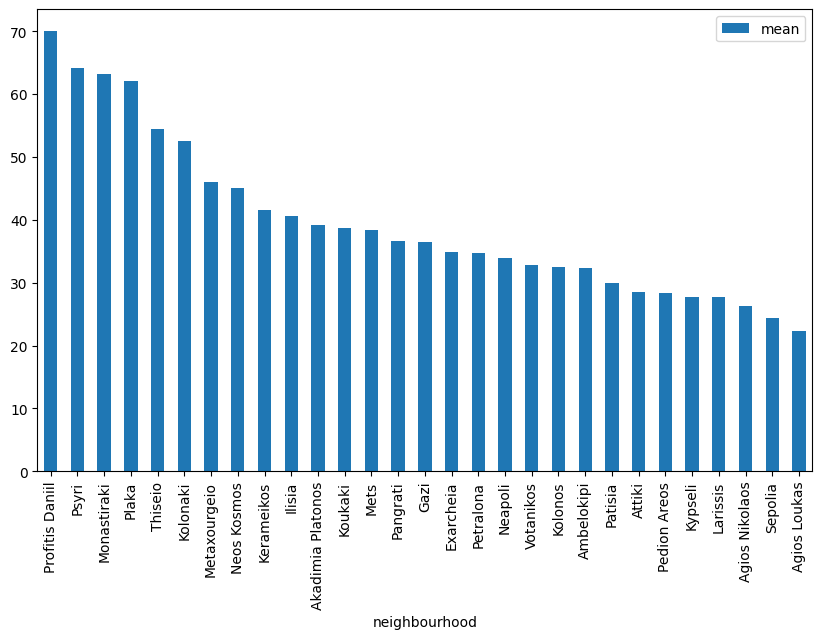

In [ ]:
grouped = df[df['accommodates'] == 2].groupby('neighbourhood')['price'].agg(['count', 'mean']).reset_index()
sorted = (grouped.sort_values(by='mean', ascending=False).reset_index(drop=True))
sorted.plot(kind='bar', x='neighbourhood', y= 'mean', figsize=(10, 6))
nei=sorted['neighbourhood'].tolist()
print(f'ExpensiveNeighbourhoods:{nei[:10]}\nMiddlePriceNeighbourhoods:{nei[10:19]}\nInexpensiveNeighbourhoods:{nei[20:30]}')

# 1.13

Neighbourhood with the best review score.

Most common cancellation policy.

Room per month.

<Figure size 1000x600 with 0 Axes>

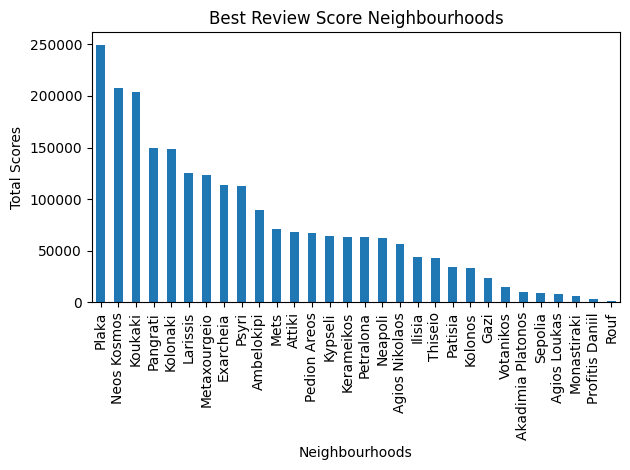

Best review_score neighbourhoods
        neighbourhood  review_scores_rating
23              Plaka         249156.860787
18        Neos Kosmos         207302.291208
11            Koukaki         204242.806286
19           Pangrati         149087.152050
9            Kolonaki         148521.459083
13           Larissis         125117.154927
14       Metaxourgeio         123551.558070
5           Exarcheia         114085.667128
25              Psyri         112381.398827
3          Ambelokipi          89396.890942
15               Mets          71548.015769
4              Attiki          67962.872296
21       Pedion Areos          67625.176451
12            Kypseli          64697.421789
8          Kerameikos          63610.139158
22          Petralona          63418.301278
17            Neapoli          62756.975599
1      Agios Nikolaos          56116.157804
7              Ilisia          44103.893820
28            Thiseio          43055.691529
20            Patisia          34526.751784

In [ ]:
grouped_df = df.groupby('neighbourhood')['review_scores_rating'].sum().reset_index()
sorted_df = grouped_df.sort_values(by='review_scores_rating', ascending=False)

plt.figure(figsize=(10, 6))
sorted_df.plot(kind='bar', x='neighbourhood', y='review_scores_rating', legend=False)
plt.title('Best Review Score Neighbourhoods')
plt.xlabel('Neighbourhoods')
plt.ylabel('Total Scores')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

print("Best review_score neighbourhoods")
print(sorted_df)

In [ ]:
table = PrettyTable(["Cancellation Policy", "Count"])
grouped = df.groupby('cancellation_policy').size().sort_values(ascending = False)
for canc_pol, count in grouped.items():
    table.add_row([canc_pol, count])
print(table)

+-----------------------------+-------+
|     Cancellation Policy     | Count |
+-----------------------------+-------+
|           moderate          |  8326 |
| strict_14_with_grace_period |  7910 |
|           flexible          |  7446 |
|       super_strict_60       |   61  |
|       super_strict_30       |   49  |
|            strict           |   21  |
+-----------------------------+-------+


         room_type  April  February  March  Total
0  Entire home/apt   7300      6863   7009  21172
1     Private room    848       862    858   2568
2      Shared room     24        24     25     73


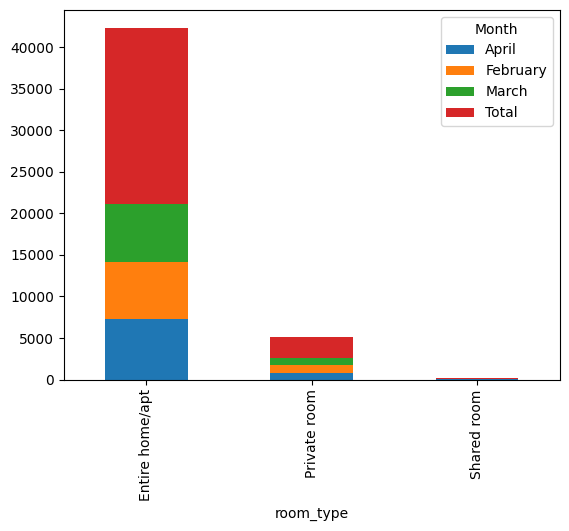

In [ ]:
neigh_counts = df.groupby(['room_type', 'Month']).size().reset_index(name='Entry_Count')
neigh_pivot = neigh_counts.pivot(index='room_type', columns='Month', values='Entry_Count').reset_index()
neigh_pivot['Total'] = neigh_pivot[['April', 'February', 'March']].sum(axis=1)
neigh_pivot = neigh_pivot.sort_values(by='Total', ascending=False)
neigh_pivot.plot(kind='bar', x='room_type', y=['April', 'February', 'March', 'Total'], stacked=True)
neigh_pivot.columns.name = None
print(neigh_pivot)

# 1.14

Hosts with most Realties.

In [ ]:
table = PrettyTable(["Host ID", "Count"])
grouped = df.groupby('host_id').size().nlargest(10)
for host_id, count in grouped.items():
    table.add_row([host_id, count])
print(table)

+-----------+-------+
|  Host ID  | Count |
+-----------+-------+
|  29927830 |  226  |
|   748818  |  201  |
|  1621474  |  185  |
| 112527018 |  157  |
| 135482892 |  144  |
|  1418201  |  119  |
|  65714690 |  110  |
| 220022946 |  107  |
|  2718115  |  105  |
| 149346682 |  103  |
+-----------+-------+


# **2.TEXT PROCESS**
Sample 5000 rows from the DataFrame , creating a new one with the specified columns.ID is index in random_df.Add a column 'language' to find the non-english strings and drop the corresponding rows. Lowercase everything and drop 'language' column.

In [ ]:
!pip install langdetect
from langdetect import detect
import re
import spacy
import nltk
nltk.download('punkt')

In [ ]:
punctuation_pattern = r'[^\w\s]'
number_pattern = r'\b\d+\b'
nlp = spacy.load('en_core_web_sm')

# to remove stopwords
def remove_stopwords(text):
    doc = nlp(text)
    text_no_stopwords = ' '.join([token.text for token in doc if not token.is_stop])
    return text_no_stopwords
# to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
# remove punctuation marks , numbers and html
def remove_html_pun_num(text):
    text_no_num = re.sub(number_pattern, '', text)
    text_no_pun = re.sub(punctuation_pattern, '', text_no_num)
    return re.compile(r'<[^>]+>').sub('', text_no_pun)

def detect_en(text):
  try:
    return detect(text)
  except:
    return 'unknown'


In [ ]:
sample_df = df.sample(5000)
random_df = sample_df[['name', 'description']].copy()
random_df['combined_text'] = random_df['name'].fillna('') + ' ' + random_df['description'].fillna('')#fill NaN values so the text process works properly

random_df['combined_text']=random_df['combined_text'].apply(remove_html_pun_num)
random_df['combined_text'] = random_df['combined_text'].apply(remove_emojis)
random_df['combined_text']=random_df['combined_text'].apply(remove_stopwords)

lang_df = random_df['combined_text'].apply(detect_en)
random_df['language'] = lang_df
rows_to_drop = random_df[random_df['language'] != 'en']
random_df = random_df.drop(rows_to_drop.index)

random_df['combined_text'] = random_df['combined_text'].str.lower()

random_df.drop('language' , axis=1)
num_rows = random_df.shape[0]
print(num_rows)
print(random_df.head(20))

4532
id
24731053    jorgoshouse recently renovated strategic centr...
20187539    sailing captains city rest convenient 50m2 apa...
30008413    iokasti suite 1st floor exarchia square   gues...
29177367    happyhouse ampelokipoiairportlinenear center c...
19670590    troop roomcenter athens troop room cozy elegan...
                                  ...                        
19796279    cozy studio heart athens brand new cozy spacio...
15574193    spacious oasis heart athens place good couples...
27443072    double room acropolis   night local tax paid site
27286176    greece u athens thissio suites     newly renov...
10325584    athens hip city apt spacious apartment fully e...
Name: combined_text, Length: 4532, dtype: object


# 2.1
Use of TfidfVectorizer , name and description concatanation , fillna and create TF-IDF matrix.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

random_df = random_df.fillna('')
tfidf_matrix = vectorizer.fit_transform(random_df['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())


# 2.2
Handle the zero values of TF-IDF with 'csr_matrix' , calculate cosine similarity ,flatten and sort the array with 'argsort' to find the indices of top 100 similar pairs.Then find the corresponding index to the df.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

tfidf_csr = csr_matrix(tfidf_df)
cos_sim_matrix = cosine_similarity(tfidf_csr, tfidf_csr)

sorted_indices = np.argsort(cos_sim_matrix, axis=None)[::-1]
top_similar = sorted_indices[:100]

num_cols_tfidf = tfidf_df.shape[1]
row_indices = top_similar // num_cols_tfidf
col_indices = top_similar % num_cols_tfidf

top_tfidf_values = tfidf_df.iloc[row_indices, col_indices]

corresponding_ids = list(random_df.iloc[row_indices].index)

print(corresponding_ids)#To copy one for the recommendation function


[28337826, 30918727, 32712799, 10080819, 30440167, 28223565, 31852468, 18056556, 30918368, 30840728, 20218055, 20218055, 17612351, 25818441, 25818441, 25019308, 20218055, 25070229, 31079427, 22078966, 10261338, 27912369, 32267604, 26469900, 18957139, 3659371, 3659371, 31079427, 11452616, 32299707, 27801579, 19027509, 26511626, 30840728, 30840728, 26511626, 26563538, 26563538, 19027509, 11562618, 24192078, 11562618, 30373137, 15651521, 11452616, 24514669, 24514669, 27188657, 17621865, 15825888, 25070229, 2787874, 7356865, 29777267, 19166025, 30371061, 31439449, 15008428, 24705085, 24705085, 5510110, 31397885, 25767004, 25767004, 31397885, 31801874, 26470416, 26470416, 24556958, 29177367, 30336739, 25366509, 16262260, 29893424, 7356865, 31439449, 19326234, 31368571, 17218832, 20080484, 17218832, 6281763, 32837007, 19659012, 2787874, 2787874, 15008428, 18056556, 27887364, 27887364, 7587337, 18056556, 18144362, 26765432, 30437081, 18374398, 26765432, 31691765, 33396369, 28628559]


# 2.3
Searching for the provided id(index) in the cosine matrix , then sorting the values to find the most similar

In [ ]:
cosine_sim_df = pd.DataFrame(cos_sim_matrix, index=random_df.index, columns=random_df.index)
def prediction(id : int , num : int):
    if id not in cosine_sim_df.index:
        raise ValueError(f"ID {id} not found in the DataFrame.")
    # if id not in cosine_sim_df.index:
    #     raise ValueError(f"ID {id} not found in the DataFrame index.")
    similarities = cosine_sim_df[id].drop(id).sort_values(ascending=False)
    return similarities.head(num)

most_similar_ids = prediction(28337826 , 10)
result_df = random_df.loc[random_df.index.isin(most_similar_ids.index)]

selected_columns = random_df.loc[random_df.index.isin(corresponding_ids), ['name', 'description']]
print()
for index, row in selected_columns.iterrows():
    print("Name:")
    print(row['name'])
    print("Description:")
    print(row['description'])
    print()


Name:
Ermou Cozy Suite @ Plaka, Queen Size Bed -5* stay
Description:
A luxury appartment with all the amenities awaits for you to live the ultimate experience in the heart of Plaka and Monastiraki. The absolute combination between a stylish and serene flat located at a vivid and active city! All the means of transport from/to the airport and from/to the port is not more than 3min walking distance!! It's extremely ideal for a shorty stay visitor and for someone who wants a base to explore Athens and whole Greece. This newly renovated, fully furnished apartment features one bedroom with a king sized bed, a cosy dining area, a brand new bathroom and a fully-equipped kitchen. The apartment can accommodate super comfortably up to 2 persons. It's decor is modern and minimalistic with a functional and cozy feel to it.  What you will enjoy: - Equipped kitchen with: Espresso coffee machine, toaster, kettle, refrigerator, hobs, mini stove, pots and pans, dishes, glasses and cutlery - Fully reno

# 2.4
Use of the combined text column from the sample DataFrame random_df to find collocations with BigramCollocationFinder

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

table = PrettyTable(['Bigram', 'Frequency'])

random_df['tokens'] = random_df['combined_text'].apply(word_tokenize)
finder = BigramCollocationFinder.from_documents(random_df['tokens'])
scored_bigrams = finder.score_ngrams(BigramAssocMeasures.raw_freq)
for bigram, freq in scored_bigrams[:10]:
    table.add_row([bigram, freq])
print(table)

+--------------------------+-----------------------+
|          Bigram          |       Frequency       |
+--------------------------+-----------------------+
|    ('living', 'room')    |  0.005673428360097429 |
|   ('metro', 'station')   |  0.005069238042856872 |
|  ('fully', 'equipped')   |  0.004741403834847422 |
| ('walking', 'distance')  | 0.0035303138267463946 |
|    ('double', 'bed')     | 0.0034571607390087486 |
|   ('center', 'athens')   |  0.002958635992944791 |
|   ('heart', 'athens')    | 0.0027743985867907197 |
| ('equipped', 'kitchen')  |  0.002544101829098131 |
| ('apartment', 'located') |  0.002091636434572691 |
|    ('city', 'center')    |  0.001674392897106118 |
+--------------------------+-----------------------+
